In [6]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
import pylab

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

In [7]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [8]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [9]:
t = Parameter('t')
num_qubits = H2_op.num_qubits
hamiltonian = create_zz_hamiltonian(num_qubits, [[0, 1]], [1.]) 
analog_block = HamiltonianGate(data=hamiltonian, time=t)

In [10]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


In [11]:
seed = 69
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [12]:
# First we need to define at least one variational parameter
theta = Parameter('a')
psi = Parameter('b')

no_qubits = H2_op.num_qubits
nlayers = 2
# Create a quantum circuit that is used for the ansatz
ansatz = QuantumCircuit(H2_op.num_qubits)
hmm = TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','ry','rz'],entanglement_blocks=analog_block,reps=nlayers,insert_barriers=True)
ansatz +=hmm
""" # add some single-qubit gates
for i in range(no_qubits-1):
    if i % 2 == 0:
        ansatz.rx(psi, i)

ansatz.rz(theta, range(no_qubits))
    
# add a chain of CNOTs (multi-qubit gates)
for i in range(no_qubits-1):
    ansatz.cx(i, i+1)
ansatz.cx(no_qubits-1,0)
ansatz.barrier() """

    

# If you have prepared a state before, you can combine it with your ansatz
# ansatz.compose(prepared_state, front=True, inplace=True)

print(ansatz.decompose().draw())

     ┌──────────┐┌──────────┐┌──────────┐ ░ ┌──────────────┐ ░ ┌──────────┐»
q_0: ┤ Rx(θ[0]) ├┤ Ry(θ[2]) ├┤ Rz(θ[4]) ├─░─┤0             ├─░─┤ Rx(θ[7]) ├»
     ├──────────┤├──────────┤├──────────┤ ░ │  Hamiltonian │ ░ ├──────────┤»
q_1: ┤ Rx(θ[1]) ├┤ Ry(θ[3]) ├┤ Rz(θ[5]) ├─░─┤1             ├─░─┤ Rx(θ[8]) ├»
     └──────────┘└──────────┘└──────────┘ ░ └──────────────┘ ░ └──────────┘»
«      ┌──────────┐┌───────────┐ ░ ┌──────────────┐ ░ ┌───────────┐»
«q_0: ─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─┤0             ├─░─┤ Rx(θ[14]) ├»
«     ┌┴──────────┤├───────────┤ ░ │  Hamiltonian │ ░ ├───────────┤»
«q_1: ┤ Ry(θ[10]) ├┤ Rz(θ[12]) ├─░─┤1             ├─░─┤ Rx(θ[15]) ├»
«     └───────────┘└───────────┘ ░ └──────────────┘ ░ └───────────┘»
«     ┌───────────┐┌───────────┐
«q_0: ┤ Ry(θ[16]) ├┤ Rz(θ[18]) ├
«     ├───────────┤├───────────┤
«q_1: ┤ Ry(θ[17]) ├┤ Rz(θ[19]) ├
«     └───────────┘└───────────┘


<ipython-input-12-fc612559de6b>:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  ansatz +=hmm


In [16]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85803
Delta from reference energy value is -0.00076


Text(0.5, 1.0, 'Convergence with no noise')

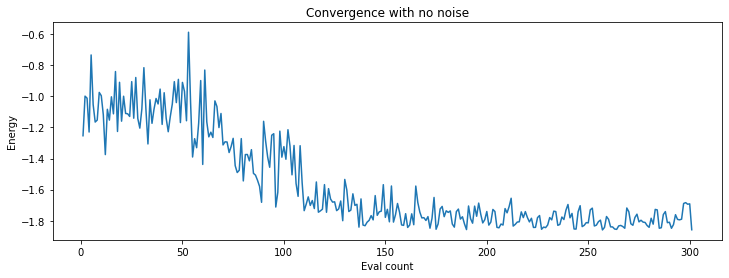

In [17]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

## Performance *with* noise

In [13]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

#var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['id', 'measure', 'x', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]

VQE on Aer qasm simulator (with noise): 

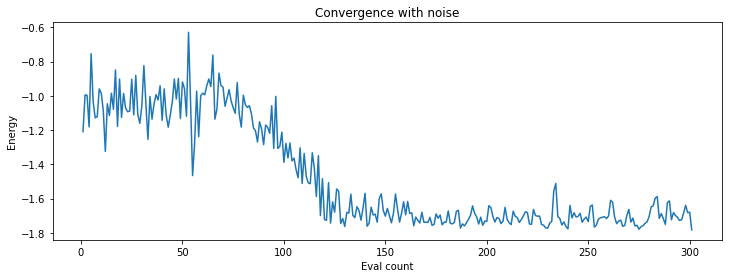

In [19]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

## Performance *with* noise and measurement error mitigation

In [20]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    #ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.86086
Delta from reference energy value is -0.00359


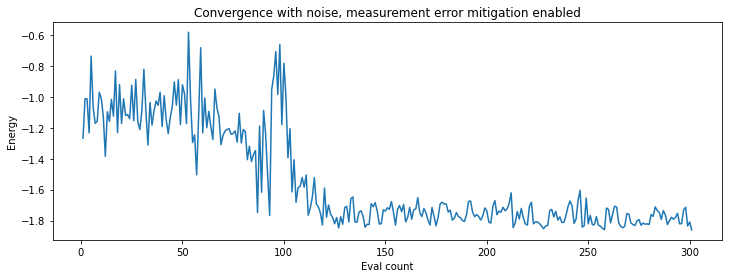

In [21]:
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled')

Lets bring the results together here for a summary. 

We produced a reference value using a classical algorithm and then proceeded to run VQE on a qasm simulator. While the simulation is ideal (no noise) there is so called shot-noise due to sampling - increasing the number of shots reduces this as more and more samples are taken, but shots was left at the default of 1024 and we see a small effect in the outcome. 

Then we added noise using a model taken off a real device and can see the result is affected. Finally we added measurement noise mitigation which adjusts the results in an attempt to alleviate the affect of noise in the classical equipment measuring the qubits.

In [22]:
print(f'Reference value: {ref_value:.5f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.85803
VQE on Aer qasm simulator (with noise): -1.78265
VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.86086


It seems that the DAQC approach works just fine at a smaller scale (here n = 2) qubits. The results are better than those obtained through Digital gates and multi qubit gates.